# Validacion 

En este documento se validan los resultados de FD-FEM y TD-FEM comparandolos con una solucion semi analitica.
Primero se definen unas dimensiones de recinto, posicion con posicion de receptor y emisor.


In [2]:
import  sys
import os 

dir_actual = os.path.abspath('')
dir_raiz = os.path.dirname(dir_actual)
# Añadir la ruta raíz al sys.path si aún no está
if dir_raiz not in sys.path:
    sys.path.append(dir_raiz)
print(f"Ruta raíz del proyecto añadida al path: {dir_raiz}")

Ruta raíz del proyecto añadida al path: /home/matias/Acoustic-Modal-Response-Optimizer


In [3]:
from mesh.mesh_3D_generator import generate_mesh_parallelepiped
#Frecuencia maxima de simulacion
f_max = 200
f_min = 20

#Dimensiones del Recinto
Lx = 3
Ly = 4
Lz = 2.5
L_floor = [Lx,Ly]
dimensions = [Lx, Ly, Lz]

#Posicion de Emisor 
Sx = 2
Sy = 0.5
Sz = 1.5
Source_position = [Sx, Sy, Sz]

#Posicion de Receptor 
Rx = 1.5
Ry = 1.3
Rz = 1.2 
Receptor_position = [Rx, Ry, Rz]

malla1 = "malla_fina_FD"

generate_mesh_parallelepiped(L_floor, Lz, Source_position, f_max, elements_per_wavelenght=10 ,name = malla1)
malla2 = "malla_gruesa_TD"

generate_mesh_parallelepiped(L_floor, Lz, Source_position, f_max, elements_per_wavelenght=5 ,name = malla2)

Se guardó el volumen como 2                                                                                                                    
INFO: Se encontraron las 7 superficies esperadas.

--- Tags de Superficies Identificadas (Resultado Final) ---
Superficie 'superior': tag geométrico 4
Superficie 'inferior': tag geométrico 6
Superficie 'frontal': tag geométrico 7
Superficie 'trasera': tag geométrico 2
Superficie 'derecha': tag geométrico 5
Superficie 'izquierda': tag geométrico 3
Superficie 'fuente': tag geométrico 1

--- Asignando Grupos Físicos ---
Grupo Físico 'superior' (Tag: 1) asignado a la geometría 4.
Grupo Físico 'inferior' (Tag: 2) asignado a la geometría 6.
Grupo Físico 'frontal' (Tag: 3) asignado a la geometría 7.
Grupo Físico 'trasera' (Tag: 4) asignado a la geometría 2.
Grupo Físico 'derecha' (Tag: 5) asignado a la geometría 5.
Grupo Físico 'izquierda' (Tag: 6) asignado a la geometría 3.
Grupo Físico 'fuente' (Tag: 7) asignado a la geometría 1.
Grupo Físico 'domin

Hacmemos una coparacion de resultados de TF y FD y Superopsicion modal


--- Cargando malla desde: mallado/malla_gruesa_TD.msh ---
Info    : Reading 'mallado/malla_gruesa_TD.msh'...
Info    : 33 entities
Info    : 1259 nodes
Info    : 6830 elements
Info    : Done reading 'mallado/malla_gruesa_TD.msh'
--- Calculando tamaño mínimo del elemento (h_min) de la malla ---
h_min global detectado: 0.203868 m

--- Determinando paso de tiempo para C=0.5 ---
Frecuencia de muestreo efectiva: 3364.9 Hz (Factor de sobremuestreo: 16.8x f_max)
Parámetros de simulación: 3365 pasos, T_final=1.000s, dt=2.97e-04s)

--- Optimizando fuente para espectro de VELOCIDAD plano ---
Fuente diseñada: Caída de -9.2 dB en los extremos. Pico de velocidad en 92.7 Hz.

--- Cargando malla desde: mallado/malla_gruesa_TD.msh ---
Info    : Reading 'mallado/malla_gruesa_TD.msh'...
Info    : 33 entities
Info    : 1259 nodes
Info    : 6830 elements
Info    : Done reading 'mallado/malla_gruesa_TD.msh'

--- Preparando Simulación Implícita y Receptores ---

--- Iniciando Bucle Temporal ---
  Progreso:

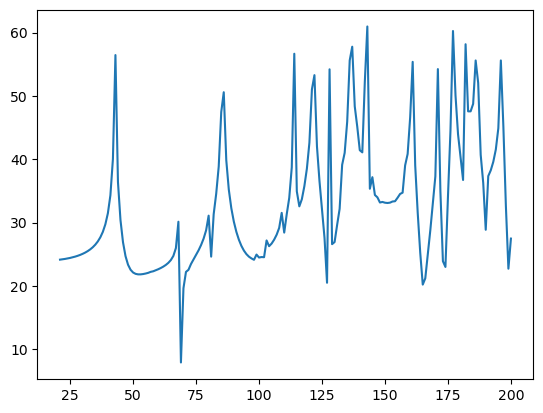

In [4]:
import numpy as np 
from matplotlib import pyplot as plt
from FEM.FEM_source_time import FEM_time_grid 
from FEM.FEM_source import FEM_Source_Solver
from FEM.mode_sumation import compute_modal_transfer
path = r"mallado/malla_gruesa_TD.msh"
td_f_response, frecs = FEM_time_grid(path, Receptor_position, f_min, f_max, deconvolve = True, save_data=False, target_courant =.5)
td_f_response = td_f_response[0] #descarto las posiciones extra de la grilla 

fs = frecs[-1] *2
detla_f = frecs[0]-frecs[1]


# Se recorta la informacion entre fmin y max
start_index = np.searchsorted(frecs, f_min, side='left')
stop_index = np.searchsorted(frecs, f_max, side='right')
print(f"Se recorta entre f: {frecs[start_index]:.2f} Hz y {frecs[stop_index - 1]:.2f} Hz")

frecs = frecs[start_index:stop_index]
td_f_response = td_f_response[start_index:stop_index]


plt.figure()
plt.plot(frecs, td_f_response)

plt.show()



Computamos la Respuesta por Superposicion Modal

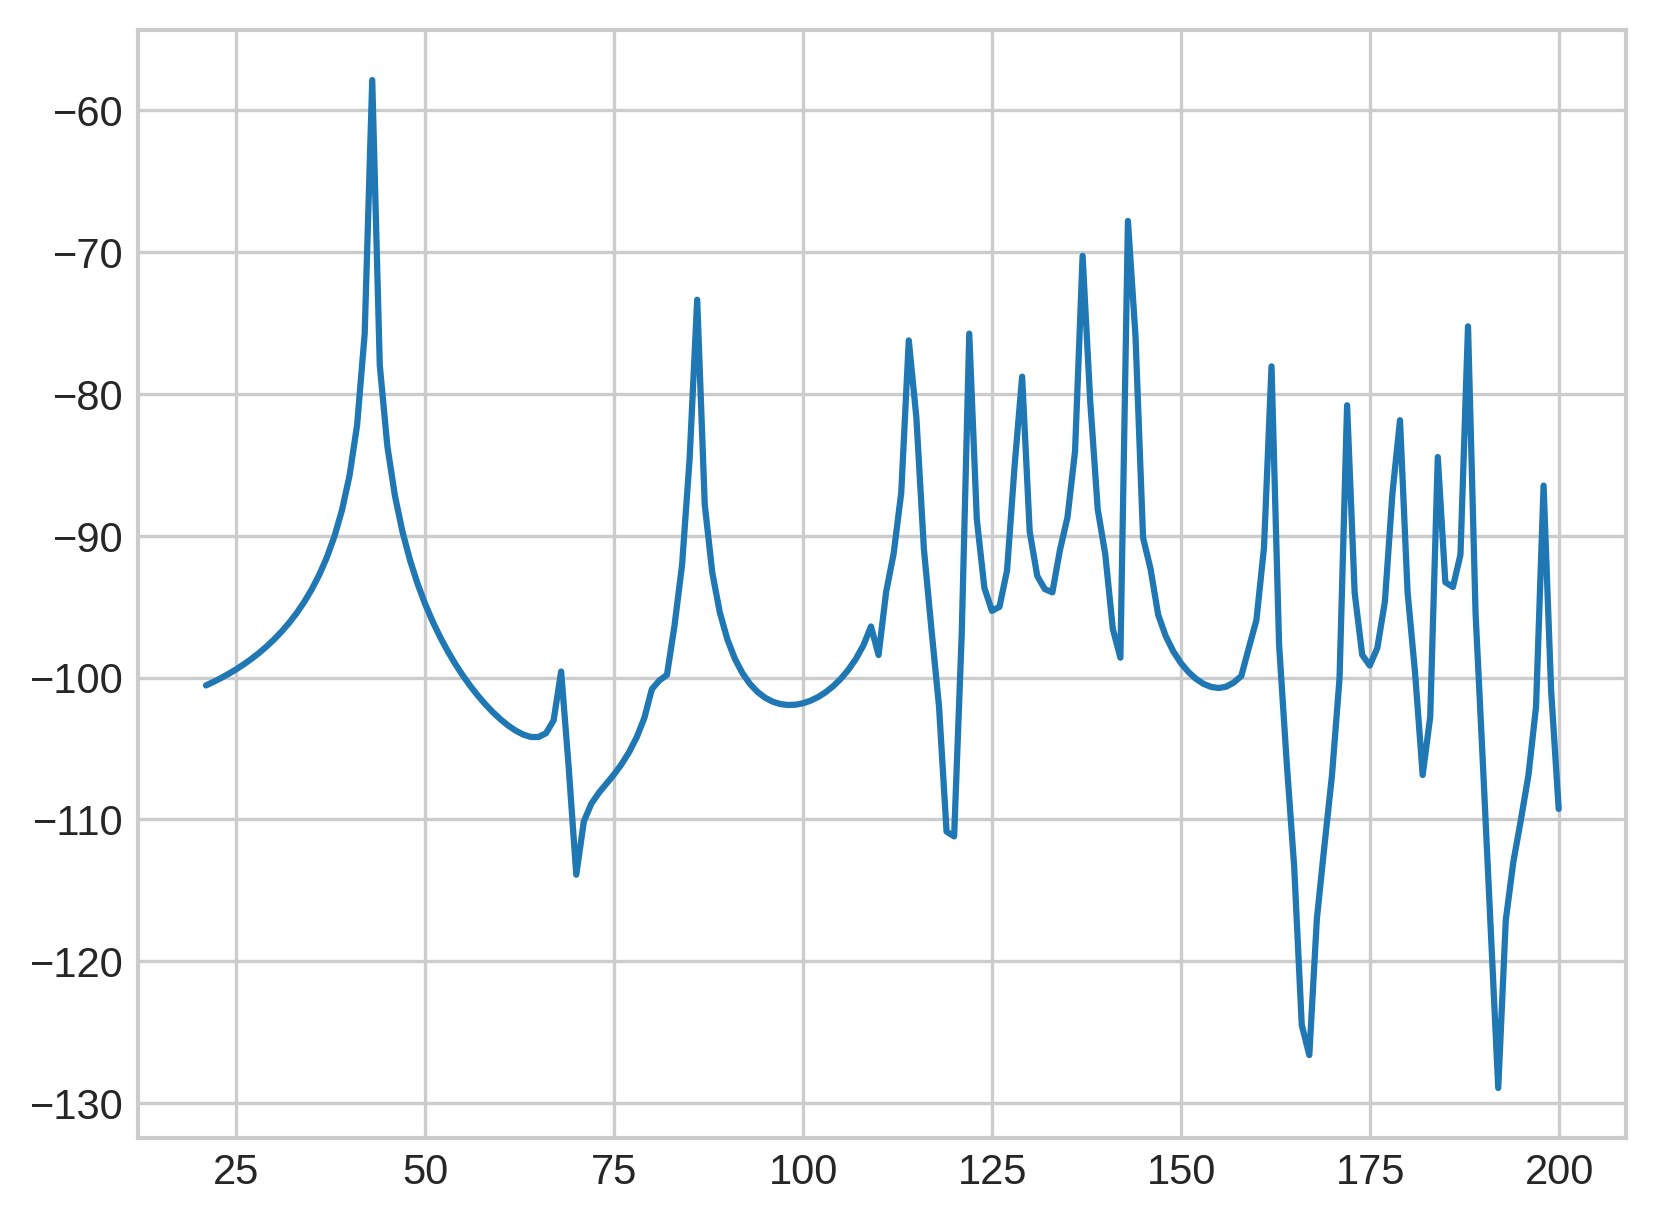

In [34]:
modal_f_response = compute_modal_transfer(Source_position, Receptor_position,dimensions, frecs, eta =1e-9 )
plt.figure()
plt.plot(frecs, modal_f_response)

plt.show()

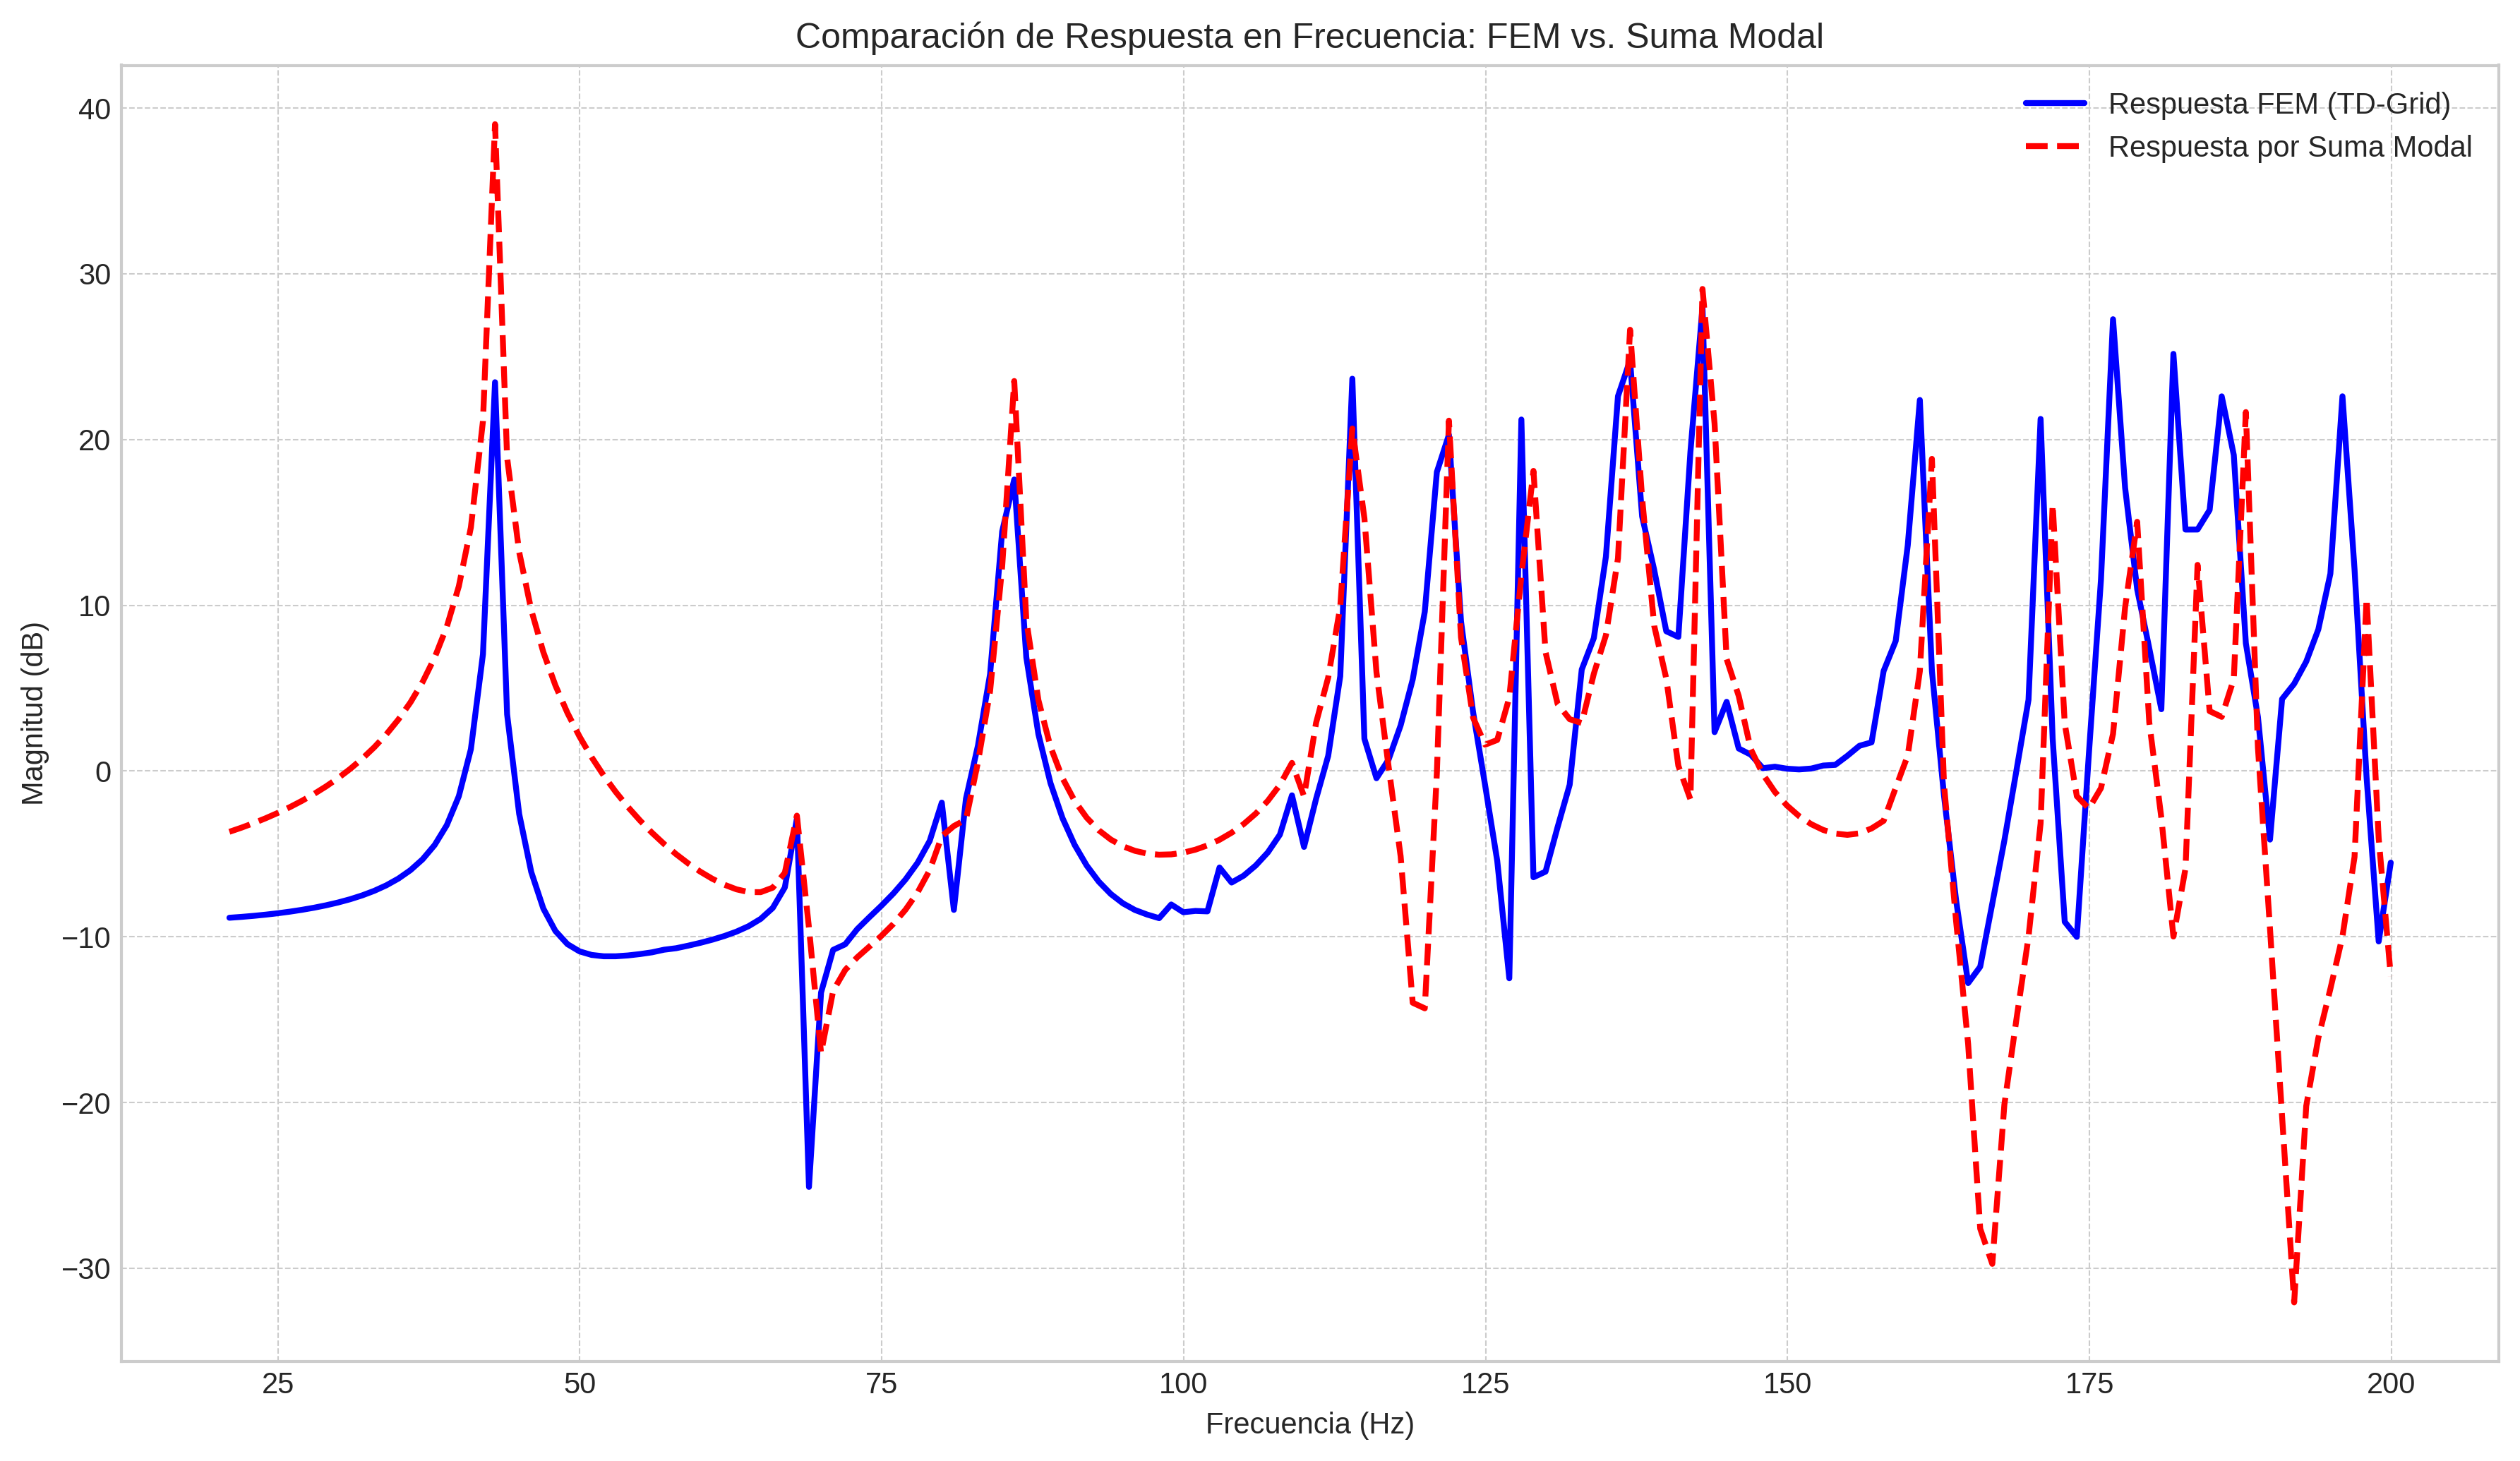

In [14]:

# --- 2. Preparar un único gráfico para la comparación ---
# Es buena práctica usar subplots para tener más control sobre la figura.
td_f_response = td_f_response - np.mean(td_f_response)
modal_f_response = modal_f_response - np.mean(modal_f_response)

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))

# --- 3. Graficar ambas curvas en los mismos ejes ---
# Graficar el resultado de FEM con una etiqueta y un estilo de línea
ax.plot(frecs, td_f_response, lw=2.0, label='Respuesta FEM (TD-Grid)', color='b')

# Graficar el resultado de la Suma Modal con otra etiqueta y estilo de línea para diferenciar
ax.plot(frecs, modal_f_response, lw=2.0, linestyle='--', label='Respuesta por Suma Modal', color='r')

# --- 4. Añadir etiquetas, título y leyenda para mayor claridad ---
ax.set_title('Comparación de Respuesta en Frecuencia: FEM vs. Suma Modal')
ax.set_xlabel('Frecuencia (Hz)')
ax.set_ylabel('Magnitud (dB)')  # Asumo que los datos están en dB
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()  # Este comando es crucial, muestra las etiquetas definidas en los 'plot'

# Opcional: puedes definir los límites de los ejes si es necesario
# ax.set_xlim(np.min(frecs), np.max(frecs))
# ax.set_ylim(-80, 10) 

# --- 5. Mostrar el gráfico combinado ---
plt.tight_layout()
plt.show()

In [29]:
from FEM.FEM_source import FEM_Source_Solver_Adaptive
malla = r"mallado/malla_gruesa_TD.msh"
fd_f_response = FEM_Source_Solver_Adaptive(frecs, malla, Receptor_position, verbose=False)

--- Iniciando solver. Modo adaptativo: True ---
Info    : Reading 'mallado/malla_gruesa_TD.msh'...
Info    : 33 entities
Info    : 1259 nodes
Info    : 6830 elements
Info    : Done reading 'mallado/malla_gruesa_TD.msh'
Radio de la esfera fuente detectado: 0.1550+0.0000j m
Frecuencia de cambio de orden: 110.5 Hz
Ejecutando 90 frecuencias con grado 1...
Ejecutando 90 frecuencias con grado 2...

--- Aplicando compensación por esfera pulsante ---
--- Simulación Finalizada ---


In [31]:
fd_f_response = fd_f_response[0] - np.mean(fd_f_response)

In [32]:
np.shape(fd_f_response)

()

ValueError: x and y must have same first dimension, but have shapes (180,) and (1,)

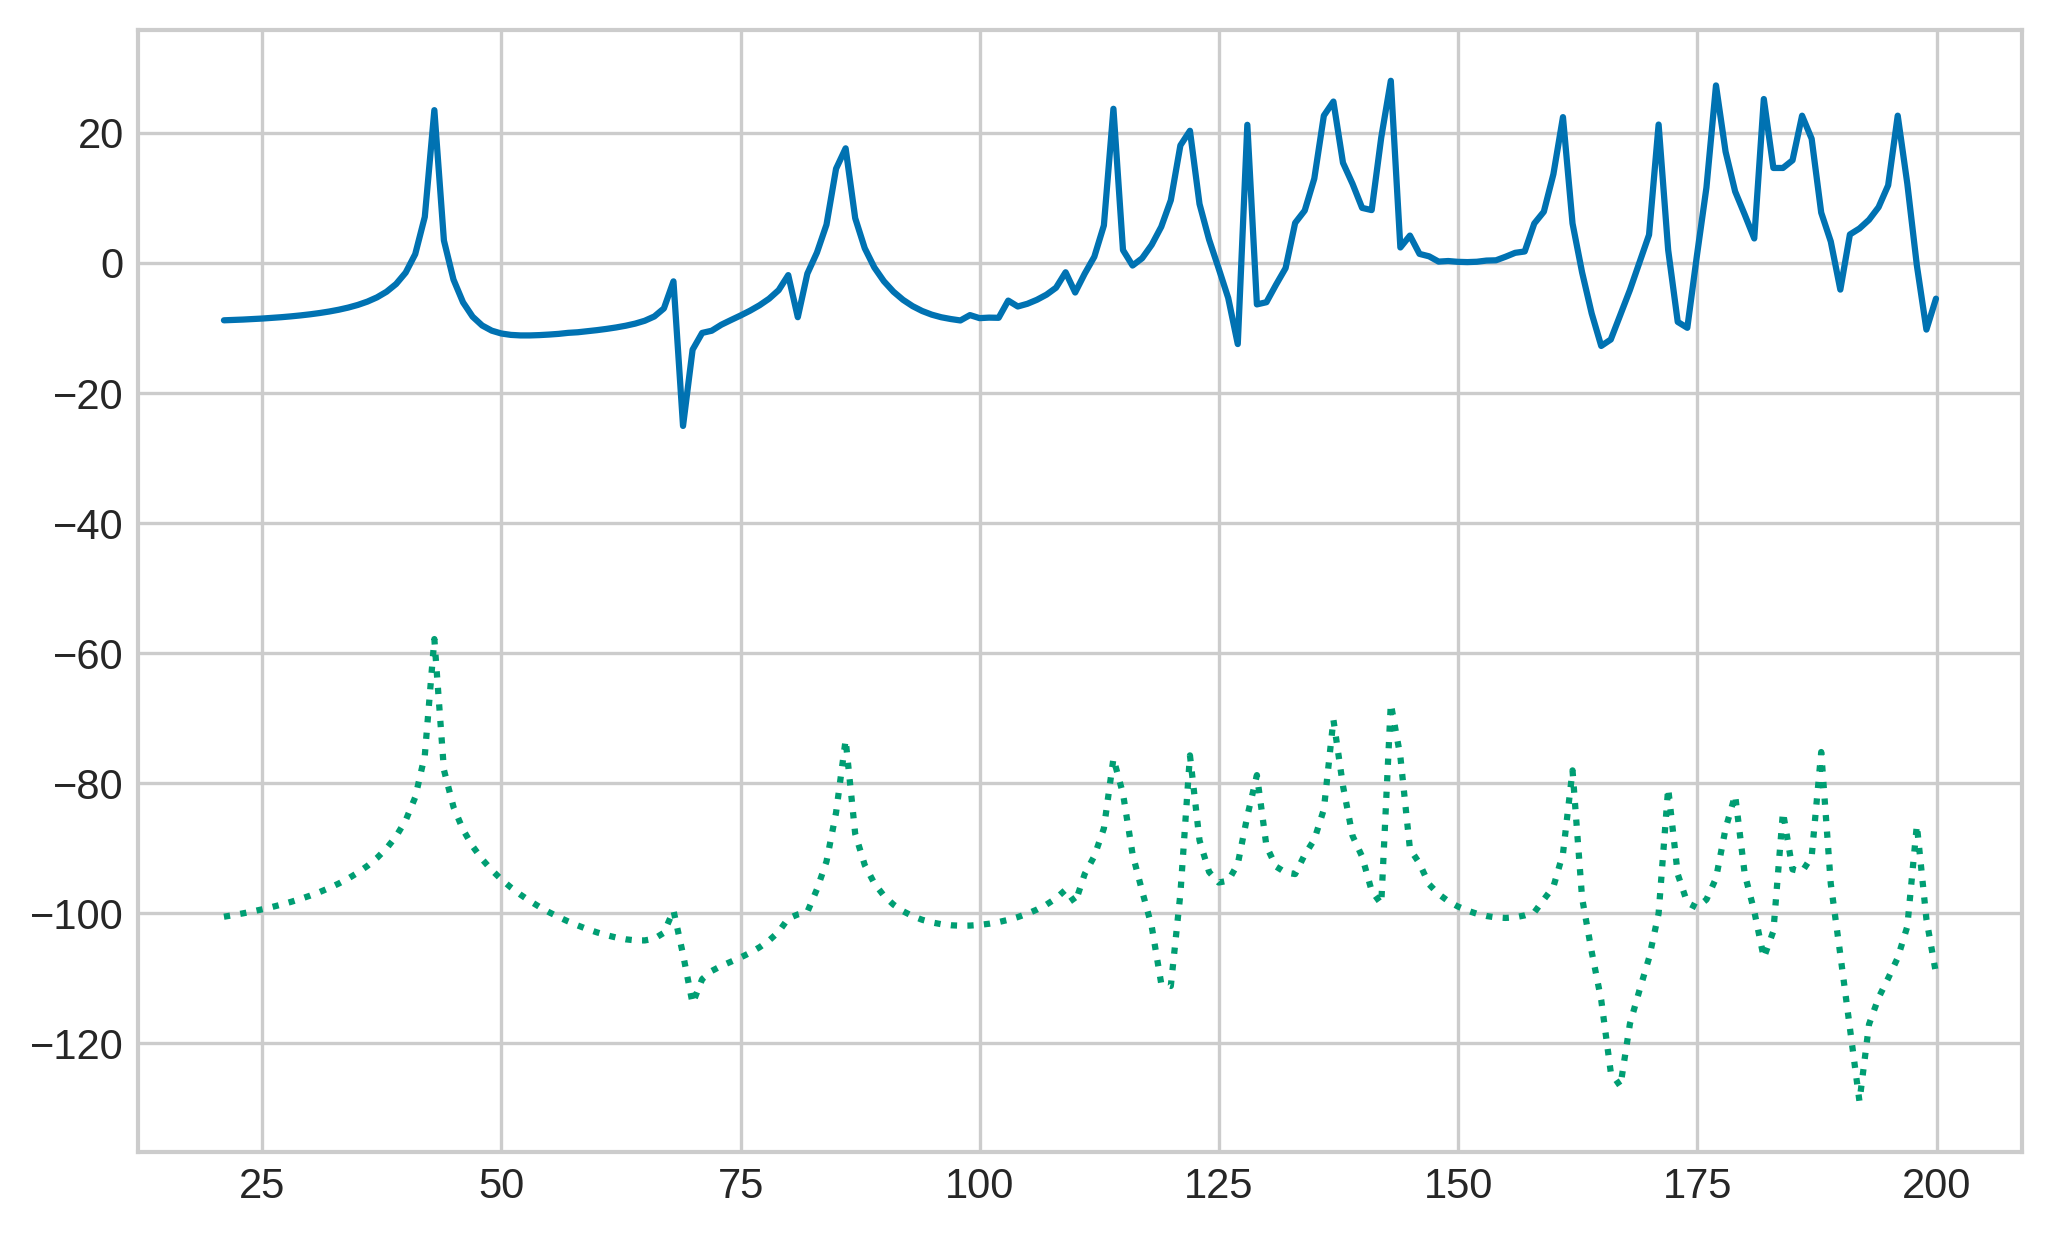

In [35]:

palette = ['#0072B2', '#009E73', '#E69F00']
# --- Configuración del gráfico (tamaño, etc.) ---
plt.rcParams['figure.dpi'] = 300
fig_width_in = 9* 0.9 
aspect_ratio = 0.6
fig_height_in = fig_width_in * aspect_ratio
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in))

# --- Graficar las curvas ---
ax.plot(frecs, td_f_response, lw=1.5, label='TD-FEM', color=palette[0])
ax.plot(frecs, modal_f_response, lw=1.5, linestyle=':', label='Suma Modal (Analítica)', color=palette[1])
ax.plot(frecs, fd_f_response, lw=1.5, linestyle='--', label='FD-FEM', color=palette[2])

# --- Etiquetas, título y leyenda ---
ax.set_title('Comparación de Modelos de Respuesta en Frecuencia', fontsize=12)
ax.set_xlabel('Frecuencia (Hz)', fontsize=10)
ax.set_ylabel('Magnitud', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=10)
ax.set_xlim(np.min(frecs), np.max(frecs))
plt.tight_layout()

# --- GUARDADO DE ARCHIVOS ---


plt.show()
